In [1]:
suppressPackageStartupMessages({
    library(Biobase)
    library(Matrix)
    library(tidyverse)
    library(stringr)

    library(pcaMethods)
    library(destiny)
    library(scran)
})

In [2]:
options(jupyter.plot_mimetypes = c('image/png', 'application/pdf'))

### kolodziejczyk

In [3]:
counts <- '~/jamboree/kolodziejczyk_2015/counts/kolodziejczk_counttable_es.tsv' %>% read.delim %>% as.matrix
annot  <- '~/jamboree/kolodziejczyk_2015/counts/kolodziejczk_annotations.tsv'   %>% read.delim
rownames(annot) <- colnames(counts)
kolodziejczyk <- newSCESet(
    countData = counts,
    phenoData = AnnotatedDataFrame(annot))
rm(annot)

In [4]:
kolodziejczyk <- kolodziejczyk %>% calculateQCMetrics(list(
    ERCC = featureNames(kolodziejczyk) %>% str_detect('^ERCC-')))

In [5]:
setSpike(kolodziejczyk) <- 'ERCC'

In [6]:
pc_counts <- pca(log1p(t(counts(kolodziejczyk))))

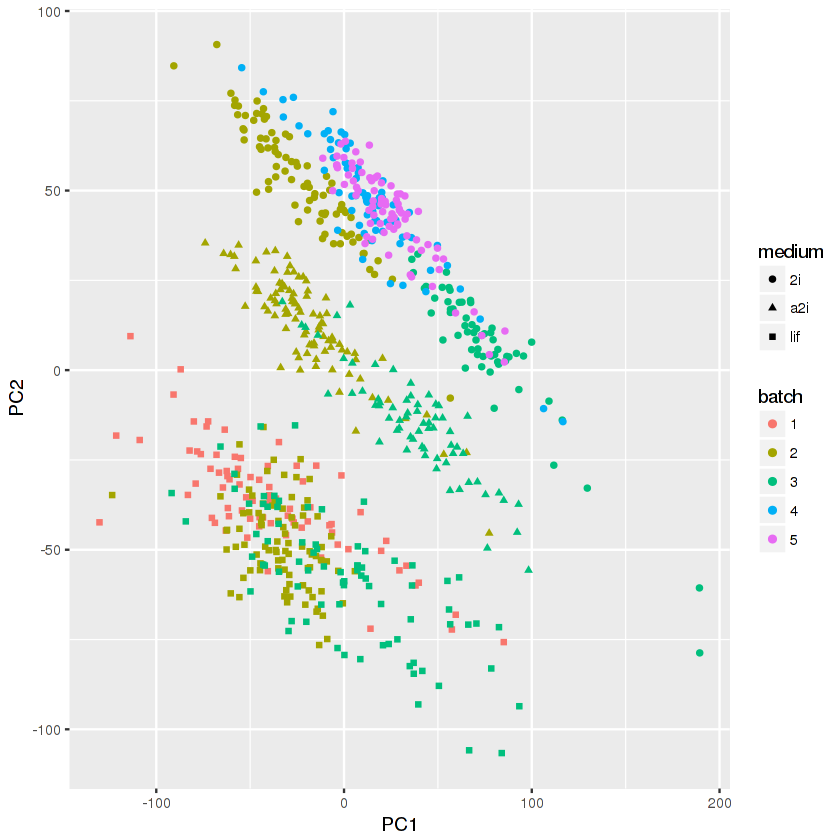

In [53]:
scores(pc_counts) %>% as.data.frame %>% cbind(pData(kolodziejczyk)) %>%
    ggplot(aes(PC1, PC2, colour = factor(batch), shape = medium)) +
        geom_point() +
        scale_colour_hue(drop = FALSE, name = 'batch')

In [8]:
kolodziejczyk_norm <- kolodziejczyk %>%
    computeSpikeFactors(general.use = TRUE) %>%
    normalize

Warning message in .local(x, ...):
“zero spike-in counts during spike-in normalization”

In [9]:
#fit <- trendVar(kolodziejczyk)
#decomp <- decomposeVar(kolodziejczyk, fit, design = model.matrix(~ kolodziejczyk$batch))
#var_genes <- decomp$bio %>% order(decreasing = TRUE) %>% head(3000)

In [10]:
kolodziejczyk_f <- kolodziejczyk_norm[, sizeFactors(kolodziejczyk_norm) > 0]

In [11]:
pc <- pca(log1p(t(exprs(kolodziejczyk_f))))

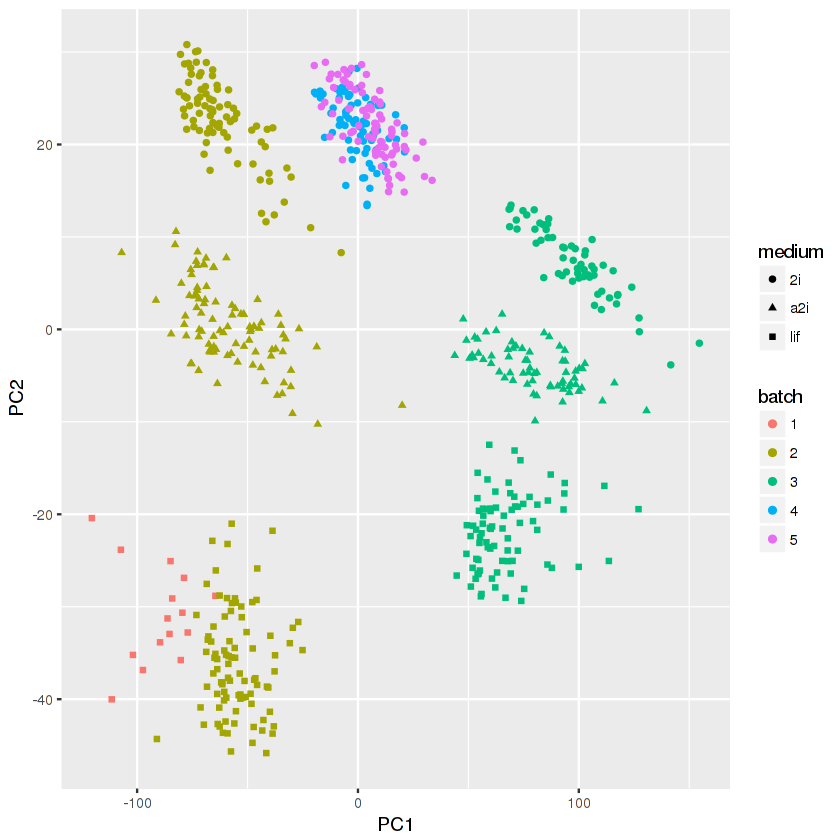

In [52]:
scores(pc) %>% as.data.frame %>% cbind(pData(kolodziejczyk_f)) %>%
    ggplot(aes(PC1, PC2, colour = factor(batch), shape = medium)) +
        geom_point() +
        scale_colour_hue(drop = FALSE, name = 'batch')

In [13]:
dm <- DiffusionMap(kolodziejczyk_f)  #[var_genes, ]

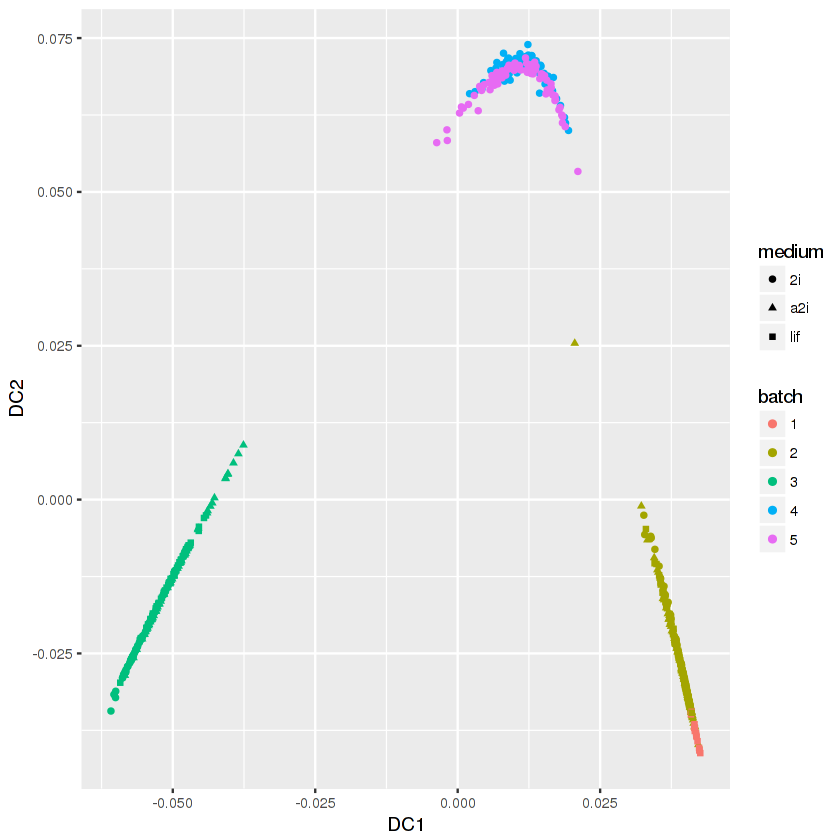

In [51]:
ggplot(dm, aes(DC1, DC2, colour = factor(batch), shape = medium)) +
    geom_point() +
    scale_colour_hue(drop = FALSE, name = 'batch')

#### mnn

In [15]:
batched <- unique(kolodziejczyk$batch) %>% sort %>% map(function(b)
    kolodziejczyk %>%
    filter(batch == b) %>%
    computeSpikeFactors(general.use = TRUE) %>%
    normalize %>%
    exprs)

Warning message in .local(x, ...):
“zero spike-in counts during spike-in normalization”

In [16]:
batched %>%
    map(function(b) b %>%
        colSums %>%
        { . > 0 } %>%
        summary %>%
        as.list %>% as.tibble %>%
        cbind(NCol = ncol(b))
    ) %>% bind_rows

Mode,TRUE,NA's,NCol
logical,15,66,81
logical,265,NA,265
logical,204,NA,204
logical,72,NA,72
logical,82,NA,82


In [24]:
corrected <- do.call(mnnCorrect, batched[-1])

In [25]:
corrected_mat <- do.call(cbind, corrected$corrected)
meta <- (2:5) %>%
    map(function(b) pData(kolodziejczyk)[kolodziejczyk$batch == b, ]) %>%
    bind_rows %>%
    `rownames<-`(colnames(corrected_mat)) %>%
    AnnotatedDataFrame

In [26]:
corrected_es <- ExpressionSet(corrected_mat, meta)

In [27]:
pc_corr <- pca(t(log(exprs(corrected_es) - min(exprs(corrected_es)) + 1)))

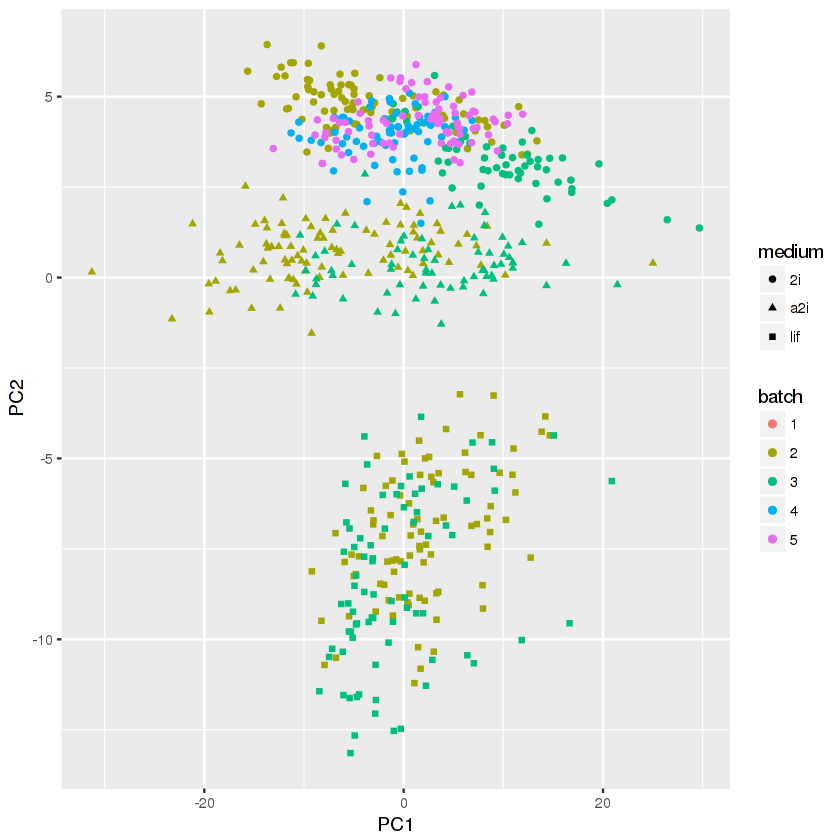

In [50]:
scores(pc_corr) %>% as.data.frame %>% cbind(pData(corrected_es)) %>%
    ggplot(aes(PC1, PC2, colour = factor(batch, levels = 1:5), shape = medium)) +
        geom_point() +
        scale_colour_hue(drop = FALSE, name = 'batch')

### zheng